In [1]:
import os
os.chdir('/home/sebastiaan/PhD/Repositories/immune_response_detection/')

from raptcr.hashing import Cdr3Hasher
from raptcr.indexing import FlatIndex
from raptcr.constants.preprocessing import add_cdr_columns, to_tcrdist3_format

import pandas as pd

In [2]:
df = pd.read_csv('./data/phil/pregibon_tcrs.tsv', sep='\t')
df = df[['cdr3b','vb','jb']]
df = add_cdr_columns(df, vcol='vb')
df = to_tcrdist3_format(df, vgenecol='vb', jgenecol='jb', cdr3col='cdr3b')
df = df.drop_duplicates()
print(df.shape, df.head())

(786, 5)           cdr3_b_aa     v_b_gene    j_b_gene cdr1_b_aa cdr2_b_aa
0    CAISESNDGNEQFF  TRBV10-3*01  TRBJ2-1*01     ENHRY    SYGVKD
1   CASTLGTSHDYEQYF   TRBV7-6*01  TRBJ2-7*01     SGHVS    FNYEAQ
2    CAISESLGQDQQYF  TRBV10-3*01  TRBJ2-7*01     ENHRY    SYGVKD
3  CAISESRSSGADTQYF  TRBV10-3*01  TRBJ2-3*01     ENHRY    SYGVKD
4   CAISESTGLRDEQFF  TRBV10-3*01  TRBJ2-1*01     ENHRY    SYGVKD


In [17]:
import faiss



In [3]:
f = Cdr3Hasher(m=256).fit()
idx = FlatIndex(hasher=f)

sequences = df.cdr3_b_aa.to_list()
idx.add(sequences)

[idx.radius_search(query=seq, r=.2) for seq in sequences]

[[],
 [],
 [('CAISESLGVDEQFF', 0.19992924)],
 [],
 [('CAISESLGVDEQFF', 0.18225414)],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [('CASSFSSNSYEQYF', 0.14343426), ('CASSFRSNSYEQYF', 0.16045476)],
 [('CASSLEGLSTDTQYF', 0.19555467)],
 [('CASSLRSNSYEQYF', 0.14441101), ('CASSLNSNSYEQYF', 0.16200536)],
 [('CASSKRTDSYEQYF', 0.1650216)],
 [('CASSLYADSYEQYF', 0.17467988),
  ('CASSFRTDSYEQYF', 0.12640122),
  ('CASSLRSNSYEQYF', 0.17368041),
  ('CASSKRTDSYEQYF', 0.12061371),
  ('CASSLRSSYEQYF', 0.19773349),
  ('CASSLETGSYEQYF', 0.15900035)],
 [('CASSLDGNNYGYTF', 0.16941777),
  ('CASSLQGTGYGYTF', 0.19773439),
  ('CASRDVGGNYGYTF', 0.18882948)],
 [('CASSLKTDSYEQYF', 0.17467988)],
 [('CASSFFSNAYEQYF', 0.14343426),
  ('CASSLRSNSYEQYF', 0.16160072),
  ('CASSFRSNSYEQYF', 0.08100818),
  ('CASSLNSNSYEQYF', 0.13138129)],
 [('CASSFLSTDTQYF', 0.18396133), ('CASSLRSTDTQYF', 0.18637106)],
 [('CASSLKTDSYEQYF', 0.12640122),
  ('CASSLRSNSYEQYF', 0.19957818),
  ('CASSFRSNSYEQYF', 0.12665434),
  ('CASSKR

In [15]:
f = Cdr3Hasher(m=256).fit()
idx = FlatIndex(hasher=f)

sequences = df.sample(10000).junction_aa.to_list()
idx.add(sequences)

In [16]:
search_result = [idx.radius_search(query=seq, r=.2) for seq in sequences]

## Faiss indices
Testing different faiss indices and their ability to retrieve neighbours using the `range_search` method.

In [1]:
import os
os.chdir('/home/sebastiaan/PhD/Repositories/immune_response_detection/')

from raptcr.hashing import Cdr3Hasher

import faiss
import time as t
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
size = 100000

# Input data
chunks = pd.read_csv('./raptcr/datasets/1m_sequences.tsv', sep='\t', chunksize=size)
data = next(chunks)

# Generate vectors
m = 256 # vector length
hasher = Cdr3Hasher(m=m).fit() # embedding function
sequences = data.junction_aa.to_list()
xb = hasher.transform(sequences).astype(np.float32) # get vector embedding of aa sequences

# Generate query
queries = next(chunks).junction_aa.to_list()
xq = hasher.transform(queries).astype(np.float32)

print(xb.shape)
print(xq.shape)

# Keep track of sequences and their index
ids = {n:i for n,i in enumerate(sequences)}

(100000, 256)
(100000, 256)


### IndexFlatL2
Basic index structure for exhaustive searching.

In [3]:
# Build index
index = faiss.IndexFlatL2(m)
index.add(xb)

# Search on the index
t0 = t.time()
search_result = [index.range_search(x=np.expand_dims(i, axis=0), thresh=.2) for i in xq]
t1 = t.time()
baseline = np.round((t1-t0)*1000, 1)

nground = sum([len(i[2]) for i in search_result])

### IndexIVFFlat
Inverted file with exact 'post-verification'. Uses product quantization to limit search space at query time.

In [6]:
# Build index
ncentroids = 1000
quantizer = faiss.IndexFlatL2(m)
index = faiss.IndexIVFFlat(quantizer, m, ncentroids)
index.train(xb)
index.add(xb)

In [141]:
# [index.range_search(x=np.expand_dims(i, axis=0), thresh=.2) for i in xq]
# index.range_search(x=np.expand_dims(xq[0], axis=0), thresh=.2)

In [7]:
runtime = []
ntotal = []

for n in range(1,101):
    index.nprobe = n
    # Search on the index
    t0 = t.time()
    search_result = [index.range_search(x=np.expand_dims(i, axis=0), thresh=.2) for i in xq]
    t1 = t.time()
    elapsed = np.round((t1-t0)*1000, 1)
    # Save results to list
    ntotal.append(sum([len(i[2]) for i in search_result]))
    runtime.append(elapsed)

In [36]:
results = pd.DataFrame(
    {'runtime':runtime, 'neighbors':ntotal, 'nprobe':[i for i in range(1,101)]}
    )

results['retrieval_rate'] = results['neighbors'] / nground
results['rel_runtime'] = results['runtime'] / baseline
results.head()

,runtime,neighbors,nprobe,retrieval_rate,rel_runtime
0,5057.8,459051,1,0.297460,0.009200
1,5694.8,698159,2,0.452399,0.010358
2,6365.4,856108,3,0.554749,0.011578
3,7262.6,968006,4,0.627257,0.013210
4,7932.3,1052796,5,0.682200,0.014428


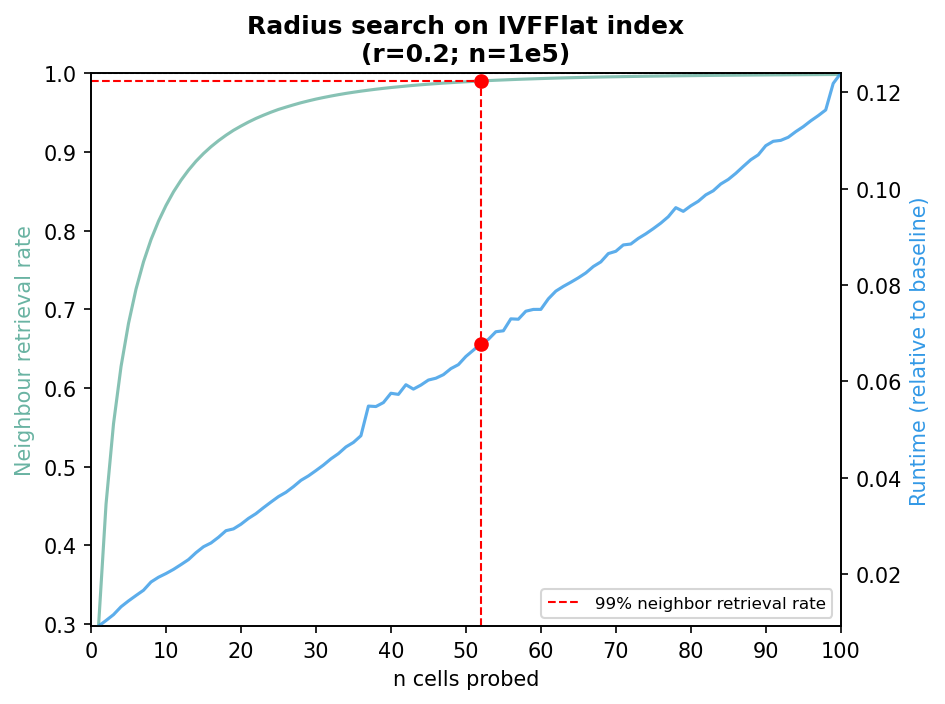

In [59]:
fig, ax1 = plt.subplots(dpi=150)

x = [i for i in range(1,101)]
y1 = [i / nground for i in ntotal] # retrieval rate
y2 = [i / baseline for i in runtime]

ax2 = ax1.twinx()
ax1.plot(x, y1, c="#69b3a2", alpha=.8, zorder=0)
ax2.plot(x, y2, c="#3399e6", alpha=.8, zorder=0)

ax1.set_xlabel('n cells probed')
ax1.set_ylabel('Neighbour retrieval rate', color="#69b3a2")
ax2.set_ylabel('Runtime (relative to baseline)', color="#3399e6")

ax1.axhline(y=1, c='black', ls='--', lw=.5)


ax1.plot(
    [0,52],
    [0.990263, 0.990263], 
    c='red', ls='--', lw=1,
    label='99% neighbor retrieval rate'
    )
ax1.plot(
    [52,52],
    [0.297460, 0.990263], 
    c='red', ls='--', lw=1
    )

# ax2.plot(
#     [52,100],
#     [0.067833, 0.067833], 
#     c='red', ls='--', lw=1,
#     label='99% neighbor retrieval rate'
#     )

ax1.scatter(
    x=52, y=0.990263, 
    c='red'
    )

ax2.scatter(
    x=52, y=0.067833, 
    c='red'
    )

ax1.set_xticks(range(0,101,10))
ax1.set_xticklabels(range(0,101,10))
ax1.legend(fontsize=8, loc='lower right')
ax1.set_xlim(0,100)


ax1.set_title('Radius search on IVFFlat index\n(r=0.2; n=1e5)', fontweight='bold')

ymin = results.retrieval_rate.min()
ymax = 1
ax1.set_ylim(ymin,ymax)

ymin = results.rel_runtime.min()
ymax = results.rel_runtime.max()
ax2.set_ylim(ymin, ymax) 

fig.tight_layout()
fig.savefig('neighbor_retrieval_indexivfflat.png', format='png', dpi=500)
fig.savefig('neighbor_retrieval_indexivfflat.pdf', format='pdf', dpi=500)

In [88]:
import faiss
import numpy as np



idx.add(xb)

rndm = random.sample(range(df.shape[0]),10)

seq = []
nneighbours = []
threshold = []
for s in rndm:
    for r in np.arange(0,2,.1):
        for n in range(df.shape[0]):
            xq = xb[np.array([s]), :]
            lim, D, I = idx.range_search(x=xq, thresh=r)
            nneighbours.append(len(I))
            seq.append(df.cdr3_b_aa.to_list()[s])
            threshold.append(r)



In [89]:
res = pd.DataFrame({'Sequences':seq, 'nn':nneighbours, 't':threshold})
res

,Sequences,nn,t
0,CASSLGGEPGELFF,0,0.0
1,CASSLGGEPGELFF,0,0.0
2,CASSLGGEPGELFF,0,0.0
3,CASSLGGEPGELFF,0,0.0
4,CASSLGGEPGELFF,0,0.0
...,...,...,...
157195,CASSGRSTDTQYF,786,1.9
157196,CASSGRSTDTQYF,786,1.9
157197,CASSGRSTDTQYF,786,1.9
157198,CASSGRSTDTQYF,786,1.9


Text(0, 0.5, 'Radius (L2 distance)')

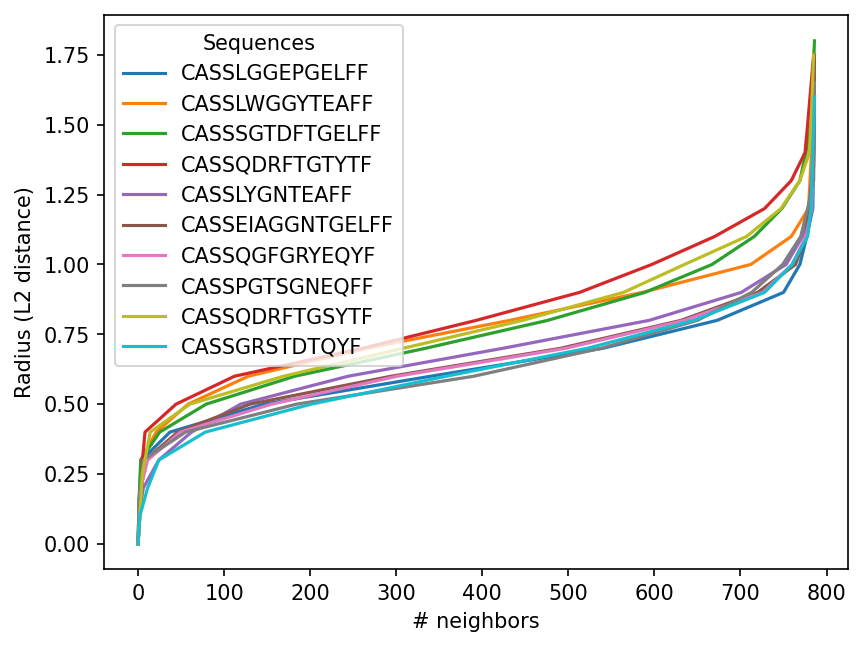

In [90]:
import seaborn as sns

fig, ax = plt.subplots(dpi=150)

sns.lineplot(
    x='nn',
    y='t',
    data=res,
    hue='Sequences',
    ax=ax
)

ax.set_xlabel('# neighbors')
ax.set_ylabel('Radius (L2 distance)')

In [7]:

I




array([  0, 106, 109, 499, 511, 516, 559])

In [76]:
xq.shape

(1, 64)

In [71]:
from scipy.spatial.distance import euclidean

for i in xb:
    print(euclidean(i, xq.flatten()))

0.8771599531173706
0.9586937427520752
0.9076681137084961
0.987409234046936
1.013145923614502
0.9399875998497009
1.0892831087112427
0.9708049297332764
0.8562821745872498
0.8485726714134216
0.8409149050712585
0.9250931143760681
1.1495112180709839
0.919161856174469
1.1180773973464966
0.9792617559432983
0.801357090473175
0.8902169466018677
0.733530580997467
0.9475501179695129
0.746366560459137
0.8272486925125122
0.8019099831581116
0.7075169086456299
0.8182558417320251
0.8025254011154175
0.7146595120429993
0.9220012426376343
0.7143070101737976
0.8578916788101196
0.6883699893951416
1.0775706768035889
1.1257603168487549
1.0533767938613892
1.0544617176055908
0.9707089066505432
0.9878528118133545
1.0189679861068726
1.3198342323303223
0.8818871974945068
1.0920904874801636
1.098387360572815
1.089103102684021
0.8674939274787903
1.1218656301498413
0.8360196352005005
0.9616144895553589
0.9930498600006104
1.0925321578979492
1.168060541152954
1.0854344367980957
0.9782784581184387
1.0617698431015015
0.